# Chapter 2: Working with Text Data & Tokenization

**Portfolio Project: Building LLMs from Scratch on AWS** 📝

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yourusername/llm-from-scratch-aws/blob/main/02_Text_Data_Tokenization.ipynb)

---

## 📋 Chapter Overview

Learn how to process text data for LLM training:
- Text tokenization methods (BPE, WordPiece)
- Creating and managing vocabularies
- Token embeddings and positional encodings
- Building efficient data loaders
- AWS S3 integration for datasets

**Learning Objectives:**
✅ Implement tokenization from scratch  
✅ Understand BPE algorithm  
✅ Create custom vocabularies  
✅ Build PyTorch data loaders  
✅ Store/retrieve datasets from S3  

**AWS Services:** S3 (data storage)  
**Estimated Cost:** $0.10 - $1.00

---

## 🔧 Environment Setup

### Cell Purpose: Install packages and configure AWS SDK

In [3]:
# Install required packages
import sys

IN_COLAB = 'google.colab' in sys.modules
IN_SAGEMAKER = '/opt/ml' in sys.executable

print(f"Environment: {'Colab' if IN_COLAB else 'SageMaker' if IN_SAGEMAKER else 'Local'}")

if IN_COLAB or IN_SAGEMAKER:
    !pip install -q torch tiktoken matplotlib numpy pandas boto3 s3fs
    print("✅ Packages installed!")

Environment: Colab
✅ Packages installed!


### Cell Purpose: Import libraries and verify installation

In [4]:
# Import all required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
import re
from collections import Counter
from importlib.metadata import version
import json

# Try to import AWS SDK
try:
    import boto3
    import s3fs
    AWS_AVAILABLE = True
    print("✅ AWS SDK available")
except ImportError:
    AWS_AVAILABLE = False
    print("⚠️  AWS SDK not available (optional)")

print("="*60)
print("LIBRARY VERSIONS")
print("="*60)
print(f"PyTorch: {version('torch')}")
print(f"Tiktoken: {version('tiktoken')}")
print(f"NumPy: {version('numpy')}")
print(f"CUDA: {torch.cuda.is_available()}")
print("="*60)

✅ AWS SDK available
LIBRARY VERSIONS
PyTorch: 2.9.0+cu126
Tiktoken: 0.12.0
NumPy: 2.0.2
CUDA: False


## 2.1 Understanding Tokenization

Tokenization breaks text into smaller units (tokens) that can be processed by neural networks.

### Why Tokenization?
- Neural networks work with numbers, not text
- Need to convert words/characters into numeric IDs
- Balance between vocabulary size and granularity

### Tokenization Methods:
1. **Character-level**: ['H', 'e', 'l', 'l', 'o']
   - ✅ Small vocabulary
   - ❌ Long sequences
   
2. **Word-level**: ['Hello', ',', 'world', '!']
   - ✅ Semantic meaning
   - ❌ Large vocabulary, OOV issues
   
3. **Subword (BPE)**: ['Hello', ',', 'world', '!']
   - ✅ Balance of both
   - ✅ Handles rare words
   - ✅ Used by GPT, BERT

### Byte Pair Encoding (BPE):
- Iteratively merges most frequent character pairs
- Creates a vocabulary of subword units
- Used by GPT-2, GPT-3, GPT-4

### Cell Purpose: Demonstrate different tokenization approaches on sample text

In [5]:
# Compare different tokenization methods
sample_text = "Hello, world! This is a tokenization example."

print("="*60)
print("TOKENIZATION COMPARISON")
print("="*60)

# Character-level
char_tokens = list(sample_text)
print(f"\n1. Character-level ({len(char_tokens)} tokens):")
print(f"   {char_tokens[:20]}...")

# Word-level (simple)
word_tokens = sample_text.split()
print(f"\n2. Word-level ({len(word_tokens)} tokens):")
print(f"   {word_tokens}")

# Subword (using tiktoken - GPT-2 tokenizer)
tokenizer = tiktoken.get_encoding("gpt2")
subword_tokens = tokenizer.encode(sample_text)
decoded_tokens = [tokenizer.decode([t]) for t in subword_tokens]

print(f"\n3. BPE Subword ({len(subword_tokens)} tokens):")
print(f"   Token IDs: {subword_tokens}")
print(f"   Decoded: {decoded_tokens}")

# Vocabulary sizes
print(f"\n📊 Vocabulary Sizes:")
print(f"   Character-level: ~100-256")
print(f"   Word-level: 50,000-100,000+")
print(f"   BPE (GPT-2): {tokenizer.n_vocab}")
print("="*60)

TOKENIZATION COMPARISON

1. Character-level (45 tokens):
   ['H', 'e', 'l', 'l', 'o', ',', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 'T', 'h', 'i', 's', ' ', 'i']...

2. Word-level (7 tokens):
   ['Hello,', 'world!', 'This', 'is', 'a', 'tokenization', 'example.']

3. BPE Subword (11 tokens):
   Token IDs: [15496, 11, 995, 0, 770, 318, 257, 11241, 1634, 1672, 13]
   Decoded: ['Hello', ',', ' world', '!', ' This', ' is', ' a', ' token', 'ization', ' example', '.']

📊 Vocabulary Sizes:
   Character-level: ~100-256
   Word-level: 50,000-100,000+
   BPE (GPT-2): 50257


## 2.2 Byte Pair Encoding (BPE) Implementation

Let's implement BPE from scratch!

### Algorithm Steps:
1. Start with character-level vocabulary
2. Count all adjacent token pairs
3. Merge most frequent pair
4. Repeat until desired vocabulary size
5. Create encoding/decoding functions

### Cell Purpose: Implement BPE tokenizer from scratch

In [6]:
# Simple BPE Implementation from Scratch
class SimpleBPETokenizer:
    '''Simple Byte Pair Encoding tokenizer implementation'''
    
    def __init__(self, vocab_size=300):
        self.vocab_size = vocab_size
        self.merges = {}
        self.vocab = {}
        
    def train(self, text):
        '''Train BPE on text corpus'''
        # Start with character-level tokens
        words = text.split()
        vocab = {' '.join(word) + ' _': 1 for word in words}
        
        # Iteratively merge pairs
        for i in range(self.vocab_size - 256):  # Reserve space for base chars
            pairs = self._get_stats(vocab)
            if not pairs:
                break
                
            best = max(pairs, key=pairs.get)
            vocab = self._merge_vocab(best, vocab)
            self.merges[best] = i
            
            if (i + 1) % 50 == 0:
                print(f"   Merge {i+1}: {best}")
        
        # Create vocabulary
        self.vocab = {char: i for i, char in enumerate(set(''.join(vocab.keys())))}
        
    def _get_stats(self, vocab):
        '''Count all adjacent pairs'''
        pairs = {}
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pair = (symbols[i], symbols[i+1])
                pairs[pair] = pairs.get(pair, 0) + freq
        return pairs
    
    def _merge_vocab(self, pair, vocab):
        '''Merge most frequent pair in vocabulary'''
        new_vocab = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        
        for word in vocab:
            new_word = word.replace(bigram, replacement)
            new_vocab[new_word] = vocab[word]
        return new_vocab
    
    def encode(self, text):
        '''Encode text to token IDs (simplified)'''
        return [self.vocab.get(c, 0) for c in text]
    
    def decode(self, tokens):
        '''Decode token IDs to text (simplified)'''
        inv_vocab = {v: k for k, v in self.vocab.items()}
        return ''.join([inv_vocab.get(t, '?') for t in tokens])

# Train on sample text
sample_corpus = """
The quick brown fox jumps over the lazy dog. 
Natural language processing is fascinating!
Machine learning models can understand text.
"""

print("\n🔧 Training BPE Tokenizer...")
print("="*60)
bpe = SimpleBPETokenizer(vocab_size=300)
bpe.train(sample_corpus)
print("="*60)
print(f"✅ Trained! Vocabulary size: {len(bpe.vocab)}")

# Test encoding/decoding
test_text = "fox jumps"
encoded = bpe.encode(test_text)
decoded = bpe.decode(encoded)
print(f"\n📝 Test: '{test_text}'")
print(f"   Encoded: {encoded[:20]}...")
print(f"   Decoded: '{decoded[:20]}...'")


🔧 Training BPE Tokenizer...
✅ Trained! Vocabulary size: 33

📝 Test: 'fox jumps'
   Encoded: [25, 5, 13, 20, 30, 16, 31, 12, 0]...
   Decoded: 'fox jumps...'


## 2.3 Using Tiktoken (Production Tokenizer)

For production use, we'll use `tiktoken` - OpenAI's BPE tokenizer.

### Benefits:
- ✅ Fast (Rust implementation)
- ✅ Compatible with GPT models
- ✅ Well-tested and maintained
- ✅ Easy to use

### Cell Purpose: Work with tiktoken tokenizer and analyze vocabulary

In [11]:
# Using Tiktoken (GPT-2/GPT-3 tokenizer)
tokenizer = tiktoken.get_encoding("gpt2")

# Example text
text = """
Large Language Models are transformer-based neural networks 
trained on vast amounts of text data. They learn to predict 
the next token in a sequence, which enables them to generate 
coherent and contextually relevant text.
"""

# Encode
tokens = tokenizer.encode(text)
print("="*60)
print("TIKTOKEN TOKENIZATION")
print("="*60)
print(f"Original text length: {len(text)} characters")
print(f"Number of tokens: {len(tokens)}")
print(f"Compression ratio: {len(text)/len(tokens):.2f} chars/token")

# Show some tokens
print(f"\n📝 First 20 tokens:")
for i in range(min(20, len(tokens))):
    token_str = tokenizer.decode([tokens[i]])
    print(f"   {tokens[i]:5d} -> '{token_str}'")

# Decode back
decoded = tokenizer.decode(tokens)
print(f"\n✅ Decoding matches original: {decoded.strip() == text.strip()}")
print("="*60)

# Vocabulary info
print(f"\n📊 GPT-2 Tokenizer Vocabulary:")
print(f"   Total tokens: {tokenizer.n_vocab:,}")
print(f"   Special tokens: <|endoftext|> (ID: {tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]})")

TIKTOKEN TOKENIZATION
Original text length: 226 characters
Number of tokens: 49
Compression ratio: 4.61 chars/token

📝 First 20 tokens:
     198 -> '
'
   21968 -> 'Large'
   15417 -> ' Language'
   32329 -> ' Models'
     389 -> ' are'
   47385 -> ' transformer'
      12 -> '-'
    3106 -> 'based'
   17019 -> ' neural'
    7686 -> ' networks'
     220 -> ' '
     198 -> '
'
   35311 -> 'trained'
     319 -> ' on'
    5909 -> ' vast'
    6867 -> ' amounts'
     286 -> ' of'
    2420 -> ' text'
    1366 -> ' data'
      13 -> '.'

✅ Decoding matches original: True

📊 GPT-2 Tokenizer Vocabulary:
   Total tokens: 50,257
   Special tokens: <|endoftext|> (ID: 50256)


### Cell Purpose: Visualize token frequency and length distribution

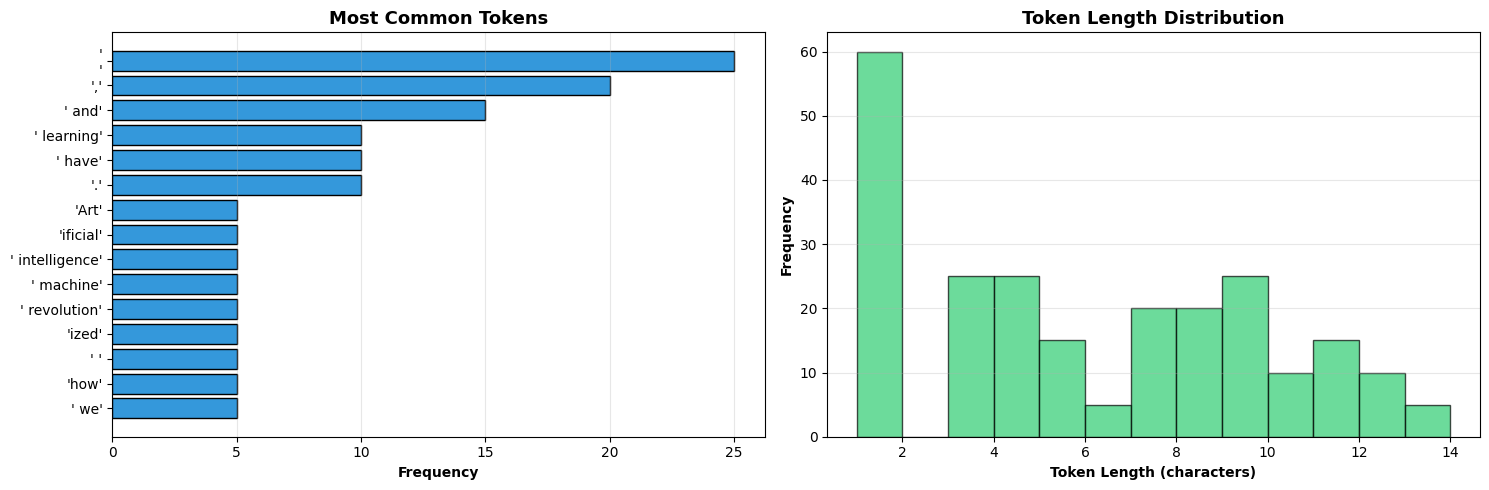

📊 Statistics:
   Unique tokens: 35
   Avg token length: 5.60 chars
   Total tokens: 235


In [12]:
# Analyze token statistics
longer_text = """
Artificial intelligence and machine learning have revolutionized 
how we process and understand natural language. Deep learning models,
particularly transformers, have achieved remarkable success in tasks
like translation, summarization, and question answering.
""" * 5  # Repeat for better statistics

tokens = tokenizer.encode(longer_text)
token_strings = [tokenizer.decode([t]) for t in tokens]

# Token frequency
token_freq = Counter(tokens)
most_common = token_freq.most_common(15)

# Token length distribution
token_lengths = [len(s) for s in token_strings]

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Most common tokens
tokens_str = [tokenizer.decode([t]) for t, _ in most_common]
counts = [c for _, c in most_common]
ax1.barh(range(len(counts)), counts, color='#3498db', edgecolor='black')
ax1.set_yticks(range(len(tokens_str)))
ax1.set_yticklabels([f"'{t}'" for t in tokens_str])
ax1.set_xlabel('Frequency', fontweight='bold')
ax1.set_title('Most Common Tokens', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Token length distribution
ax2.hist(token_lengths, bins=range(1, max(token_lengths)+2), 
         color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Token Length (characters)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Token Length Distribution', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Statistics:")
print(f"   Unique tokens: {len(set(tokens))}")
print(f"   Avg token length: {np.mean(token_lengths):.2f} chars")
print(f"   Total tokens: {len(tokens)}")

## 2.4 Token Embeddings

Convert token IDs to dense vectors that neural networks can process.

### Embedding Layer:
- Maps each token ID to a learned vector
- Typical dimensions: 128-12288 (GPT-4)
- Trained end-to-end with the model

### Why Embeddings?
- Capture semantic relationships
- Reduce dimensionality (vocab_size → d_model)
- Learn representations during training

### Example:
```
Token ID 1234 → [0.2, -0.5, 0.8, ..., 0.1]  # 768-dim vector
```

### Cell Purpose: Create and demonstrate token embedding layer

TOKEN EMBEDDINGS
Input text: 'Hello, world!'
Token IDs: [15496, 11, 995, 0]
Token tensor shape: torch.Size([1, 4])
Embedding output shape: torch.Size([1, 4, 768])
   (batch_size=1, seq_len=4, d_model=768)


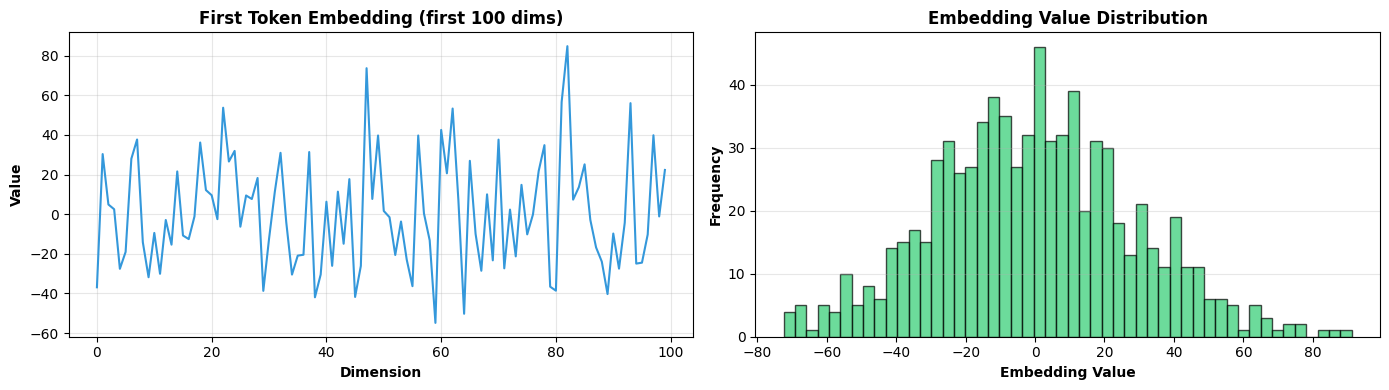


📊 Embedding Statistics:
   Mean: -0.5621
   Std: 28.5987
   Min: -72.4211
   Max: 91.1824


In [13]:
# Token Embedding Implementation
class TokenEmbedding(nn.Module):
    '''Simple token embedding layer'''
    
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        # Scale embeddings by sqrt(d_model) (as in original Transformer)
        return self.embedding(x) * np.sqrt(self.d_model)

# Create embedding layer
vocab_size = tokenizer.n_vocab  # 50,257 for GPT-2
d_model = 768  # GPT-2 embedding dimension
embedding_layer = TokenEmbedding(vocab_size, d_model)

# Example: embed some tokens
example_text = "Hello, world!"
token_ids = tokenizer.encode(example_text)
token_tensor = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension

# Get embeddings
with torch.no_grad():
    embeddings = embedding_layer(token_tensor)

print("="*60)
print("TOKEN EMBEDDINGS")
print("="*60)
print(f"Input text: '{example_text}'")
print(f"Token IDs: {token_ids}")
print(f"Token tensor shape: {token_tensor.shape}")
print(f"Embedding output shape: {embeddings.shape}")
print(f"   (batch_size=1, seq_len={len(token_ids)}, d_model={d_model})")
print("="*60)

# Visualize first embedding vector
first_embedding = embeddings[0, 0, :].numpy()
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(first_embedding[:100], color='#3498db', linewidth=1.5)
plt.xlabel('Dimension', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title(f"First Token Embedding (first 100 dims)", fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(first_embedding, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
plt.xlabel('Embedding Value', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Embedding Value Distribution', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Embedding Statistics:")
print(f"   Mean: {first_embedding.mean():.4f}")
print(f"   Std: {first_embedding.std():.4f}")
print(f"   Min: {first_embedding.min():.4f}")
print(f"   Max: {first_embedding.max():.4f}")

## 2.5 Positional Encoding

Transformers need position information since they process all tokens in parallel.

### Why Positional Encoding?
- Self-attention is permutation-invariant
- Need to inject position information
- Enables model to understand word order

### Methods:
1. **Sinusoidal (original Transformer)**: Fixed mathematical patterns
2. **Learned (GPT, BERT)**: Trainable position embeddings

### GPT-Style Learned Positional Embeddings:
```python
pos_embedding = nn.Embedding(max_seq_len, d_model)
final_embedding = token_embedding + pos_embedding
```

### Cell Purpose: Implement and visualize positional encodings

INPUT EMBEDDINGS (Token + Position)
Input: 'The transformer architecture uses self-attention.'
Tokens: torch.Size([1, 9])
Final embeddings: torch.Size([1, 9, 768])


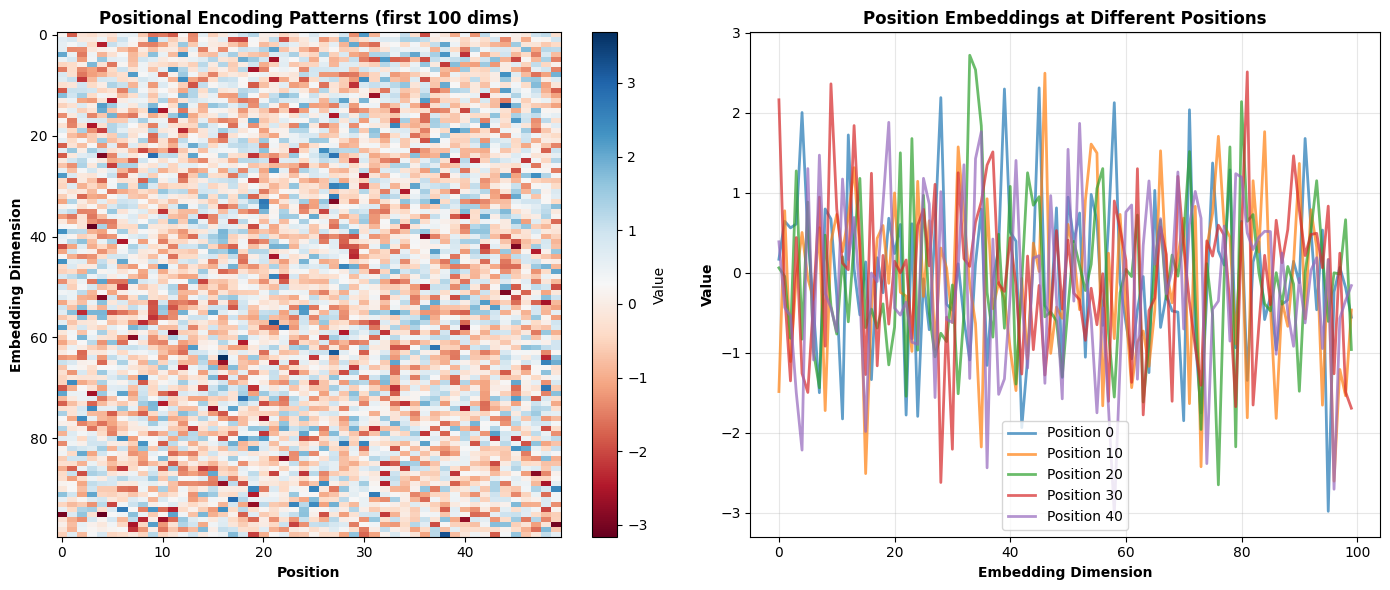


✅ Positional encodings provide unique position information for each token!


In [14]:
# Positional Encoding Implementation
class PositionalEncoding(nn.Module):
    '''Learned positional encoding (GPT-style)'''
    
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)
        
    def forward(self, x):
        batch_size, seq_len = x.shape
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        return self.pos_embedding(positions)

# Combined Token + Position Embeddings
class InputEmbedding(nn.Module):
    '''Complete input embedding: token + position'''
    
    def __init__(self, vocab_size, max_seq_len, d_model, dropout=0.1):
        super().__init__()
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(max_seq_len, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        token_emb = self.token_embedding(x)
        pos_emb = self.pos_encoding(x)
        return self.dropout(token_emb + pos_emb)

# Create input embedding layer
max_seq_len = 1024  # Maximum sequence length
input_embedding = InputEmbedding(vocab_size, max_seq_len, d_model)

# Test
test_text = "The transformer architecture uses self-attention."
token_ids = torch.tensor(tokenizer.encode(test_text)).unsqueeze(0)

with torch.no_grad():
    final_embeddings = input_embedding(token_ids)

print("="*60)
print("INPUT EMBEDDINGS (Token + Position)")
print("="*60)
print(f"Input: '{test_text}'")
print(f"Tokens: {token_ids.shape}")
print(f"Final embeddings: {final_embeddings.shape}")
print("="*60)

# Visualize positional encodings
with torch.no_grad():
    # Get first 50 position embeddings
    pos_emb = input_embedding.pos_encoding(torch.arange(50).unsqueeze(0))
    pos_matrix = pos_emb[0].numpy()

plt.figure(figsize=(14, 6))

# Heatmap of positional encodings
plt.subplot(1, 2, 1)
im = plt.imshow(pos_matrix[:, :100].T, aspect='auto', cmap='RdBu', interpolation='nearest')
plt.xlabel('Position', fontweight='bold')
plt.ylabel('Embedding Dimension', fontweight='bold')
plt.title('Positional Encoding Patterns (first 100 dims)', fontsize=12, fontweight='bold')
plt.colorbar(im, label='Value')

# Individual position embeddings
plt.subplot(1, 2, 2)
for pos in [0, 10, 20, 30, 40]:
    plt.plot(pos_matrix[pos, :100], label=f'Position {pos}', alpha=0.7, linewidth=2)
plt.xlabel('Embedding Dimension', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Position Embeddings at Different Positions', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Positional encodings provide unique position information for each token!")

## 2.6 Data Loading for LLM Training

Efficient data loading is crucial for training LLMs.

### Key Concepts:
1. **Batch Processing**: Process multiple sequences simultaneously
2. **Sequence Length**: Fixed length (e.g., 1024 tokens)
3. **Padding/Truncation**: Handle variable-length sequences
4. **Data Loaders**: PyTorch DataLoader for efficient batching

### Training Data Format:
```python
Input:  "The cat sat on"
Target: "cat sat on the"  # Shifted by 1 token
```

### Causal Language Modeling:
- Predict next token given previous tokens
- Autoregressive generation
- Self-supervised learning

### Cell Purpose: Create custom dataset and dataloader for LLM training

In [15]:
# Custom Dataset for LLM Training
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    '''Dataset for causal language modeling'''
    
    def __init__(self, text, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Tokenize entire text
        self.tokens = tokenizer.encode(text)
        
        # Calculate number of samples
        self.num_samples = len(self.tokens) // max_length
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Get chunk of tokens
        start_idx = idx * self.max_length
        end_idx = start_idx + self.max_length
        
        chunk = self.tokens[start_idx:end_idx]
        
        # Input and target (shifted by 1)
        x = torch.tensor(chunk[:-1])
        y = torch.tensor(chunk[1:])
        
        return x, y

# Create sample dataset
sample_text = """
The transformer architecture revolutionized natural language processing.
It uses self-attention mechanisms to process input sequences in parallel.
This enables efficient training on large datasets and captures long-range dependencies.
Models like GPT and BERT are based on this architecture.
""" * 10  # Repeat for more data

dataset = TextDataset(sample_text, tokenizer, max_length=64)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print("="*60)
print("DATA LOADER")
print("="*60)
print(f"Text length: {len(sample_text)} characters")
print(f"Total tokens: {len(tokenizer.encode(sample_text))}")
print(f"Dataset size: {len(dataset)} samples")
print(f"Sequence length: 64 tokens")
print(f"Batch size: 4")
print(f"Batches per epoch: {len(dataloader)}")
print("="*60)

# Get a sample batch
sample_batch = next(iter(dataloader))
inputs, targets = sample_batch

print(f"\n📦 Sample Batch:")
print(f"   Input shape: {inputs.shape}")
print(f"   Target shape: {targets.shape}")

# Show first sequence
print(f"\n📝 First Sequence in Batch:")
first_input = inputs[0, :20]
first_target = targets[0, :20]
print(f"   Input IDs: {first_input.tolist()}")
print(f"   Target IDs: {first_target.tolist()}")
print(f"\n   Input text: {tokenizer.decode(first_input.tolist())}")
print(f"   Target text: {tokenizer.decode(first_target.tolist())}")
print(f"\n   ✅ Target is input shifted by 1 token!")

DATA LOADER
Text length: 2930 characters
Total tokens: 560
Dataset size: 8 samples
Sequence length: 64 tokens
Batch size: 4
Batches per epoch: 2

📦 Sample Batch:
   Input shape: torch.Size([4, 63])
   Target shape: torch.Size([4, 63])

📝 First Sequence in Batch:
   Input IDs: [13, 198, 1212, 13536, 6942, 3047, 319, 1588, 40522, 290, 23007, 890, 12, 9521, 20086, 13, 198, 5841, 1424, 588]
   Target IDs: [198, 1212, 13536, 6942, 3047, 319, 1588, 40522, 290, 23007, 890, 12, 9521, 20086, 13, 198, 5841, 1424, 588, 402]

   Input text: .
This enables efficient training on large datasets and captures long-range dependencies.
Models like
   Target text: 
This enables efficient training on large datasets and captures long-range dependencies.
Models like G

   ✅ Target is input shifted by 1 token!


### Cell Purpose: Visualize batch structure and data flow

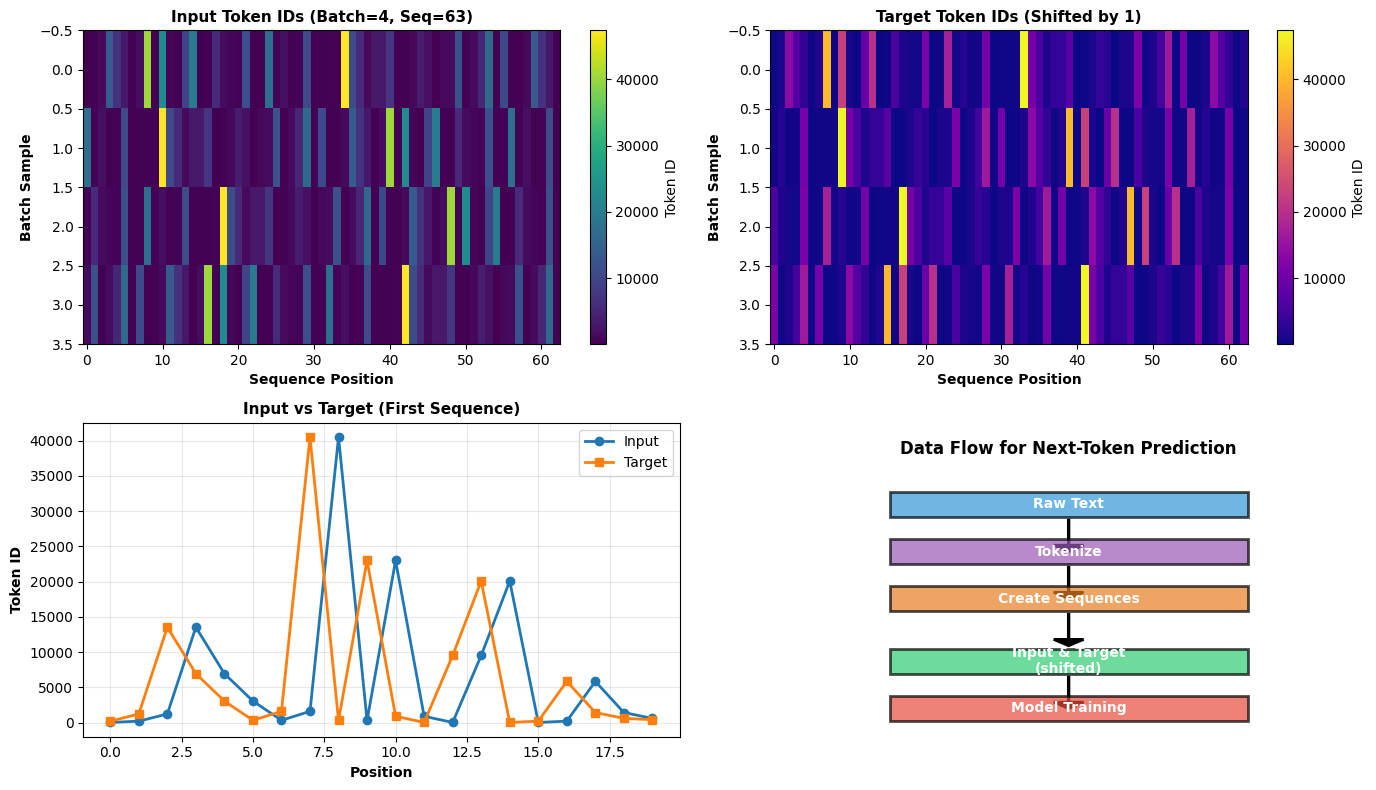

📊 The model learns by predicting the next token at each position!


In [16]:
# Visualize batch structure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Get a batch
inputs, targets = next(iter(dataloader))

# Plot 1: Token ID heatmap for inputs
ax = axes[0, 0]
im = ax.imshow(inputs.numpy(), aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_xlabel('Sequence Position', fontweight='bold')
ax.set_ylabel('Batch Sample', fontweight='bold')
ax.set_title('Input Token IDs (Batch=4, Seq=63)', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax, label='Token ID')

# Plot 2: Token ID heatmap for targets
ax = axes[0, 1]
im = ax.imshow(targets.numpy(), aspect='auto', cmap='plasma', interpolation='nearest')
ax.set_xlabel('Sequence Position', fontweight='bold')
ax.set_ylabel('Batch Sample', fontweight='bold')
ax.set_title('Target Token IDs (Shifted by 1)', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax, label='Token ID')

# Plot 3: First sequence comparison
ax = axes[1, 0]
positions = range(20)
ax.plot(positions, inputs[0, :20].numpy(), 'o-', label='Input', linewidth=2, markersize=6)
ax.plot(positions, targets[0, :20].numpy(), 's-', label='Target', linewidth=2, markersize=6)
ax.set_xlabel('Position', fontweight='bold')
ax.set_ylabel('Token ID', fontweight='bold')
ax.set_title('Input vs Target (First Sequence)', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Data flow diagram
ax = axes[1, 1]
ax.axis('off')
ax.text(0.5, 0.9, 'Data Flow for Next-Token Prediction', 
       ha='center', fontsize=12, fontweight='bold')

boxes = [
    ('Raw Text', 0.75, '#3498db'),
    ('Tokenize', 0.60, '#9b59b6'),
    ('Create Sequences', 0.45, '#e67e22'),
    ('Input & Target\n(shifted)', 0.25, '#2ecc71'),
    ('Model Training', 0.10, '#e74c3c')
]

for label, y, color in boxes:
    rect = plt.Rectangle((0.2, y-0.05), 0.6, 0.08, 
                         facecolor=color, edgecolor='black', linewidth=2, alpha=0.7)
    ax.add_patch(rect)
    ax.text(0.5, y-0.01, label, ha='center', va='center', 
           fontsize=10, fontweight='bold', color='white')
    
    if y > 0.15:
        ax.arrow(0.5, y-0.06, 0, -0.08, head_width=0.05, head_length=0.02, 
                fc='black', ec='black', linewidth=2)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("📊 The model learns by predicting the next token at each position!")

## 2.7 AWS S3 Integration

Store and retrieve large datasets from AWS S3 for cost-effective storage.

### Benefits:
- **Scalable**: Store petabytes of data
- **Cost-effective**: $0.023/GB/month
- **Durable**: 99.999999999% durability
- **Accessible**: From anywhere (SageMaker, EC2, local)

### Usage Pattern:
1. Upload datasets to S3
2. Train models using S3 data
3. Store checkpoints back to S3
4. Version control with S3 prefixes

### Cost Optimization:
- Use S3 Standard for active data
- Move to S3 Glacier for archival
- Set lifecycle policies for auto-archiving

### Cell Purpose: Demonstrate S3 data upload/download (requires AWS credentials)

In [17]:
# AWS S3 Integration (Optional - requires AWS credentials)
def save_to_s3(data, bucket_name, key, use_s3=False):
    '''Save data to S3 or local file'''
    if use_s3 and AWS_AVAILABLE:
        try:
            s3_client = boto3.client('s3')
            if isinstance(data, str):
                s3_client.put_object(Bucket=bucket_name, Key=key, Body=data.encode())
            else:
                s3_client.put_object(Bucket=bucket_name, Key=key, Body=data)
            print(f"✅ Uploaded to s3://{bucket_name}/{key}")
            return True
        except Exception as e:
            print(f"❌ S3 upload failed: {e}")
            return False
    else:
        # Save locally
        with open(key, 'w' if isinstance(data, str) else 'wb') as f:
            f.write(data)
        print(f"💾 Saved locally: {key}")
        return True

def load_from_s3(bucket_name, key, use_s3=False):
    '''Load data from S3 or local file'''
    if use_s3 and AWS_AVAILABLE:
        try:
            s3_client = boto3.client('s3')
            response = s3_client.get_object(Bucket=bucket_name, Key=key)
            data = response['Body'].read()
            print(f"✅ Downloaded from s3://{bucket_name}/{key}")
            return data
        except Exception as e:
            print(f"❌ S3 download failed: {e}")
            return None
    else:
        # Load locally
        try:
            with open(key, 'r') as f:
                data = f.read()
            print(f"💾 Loaded locally: {key}")
            return data
        except Exception as e:
            print(f"❌ Local load failed: {e}")
            return None

# Example usage (local mode by default)
print("="*60)
print("DATA STORAGE EXAMPLE")
print("="*60)

# Create sample dataset metadata
dataset_info = {
    "name": "llm_training_data",
    "num_samples": len(dataset),
    "seq_length": 64,
    "vocab_size": vocab_size,
    "tokenizer": "gpt2"
}

# Save to local file (or S3 if configured)
save_to_s3(
    json.dumps(dataset_info, indent=2),
    bucket_name="your-llm-bucket",  # Replace with your bucket
    key="dataset_info.json",
    use_s3=False  # Set to True if AWS is configured
)

print("\n💡 To use S3:")
print("   1. Configure AWS credentials (aws configure)")
print("   2. Create S3 bucket: aws s3 mb s3://your-llm-bucket")
print("   3. Set use_s3=True in the functions above")
print("="*60)

DATA STORAGE EXAMPLE
💾 Saved locally: dataset_info.json

💡 To use S3:
   1. Configure AWS credentials (aws configure)
   2. Create S3 bucket: aws s3 mb s3://your-llm-bucket
   3. Set use_s3=True in the functions above


## 📝 Chapter Summary

### What We Built:
1. ✅ **Tokenization**: BPE implementation and tiktoken usage
2. ✅ **Embeddings**: Token + positional embeddings
3. ✅ **Data Loading**: Custom Dataset and DataLoader
4. ✅ **S3 Integration**: Cloud storage for datasets
5. ✅ **Complete Pipeline**: Text → Tokens → Embeddings → Batches

### Key Takeaways:
- Tokenization converts text to numeric representations
- BPE balances vocabulary size and sequence length
- Embeddings transform discrete tokens to continuous vectors
- Positional encoding adds sequence order information
- Efficient data loading is crucial for training

### Implementation Highlights:
```python
# Complete pipeline
text → tokenizer.encode() → token_ids
token_ids → embedding_layer() → embeddings
embeddings → model → predictions
```

### AWS Services Used:
- **S3**: Dataset storage (~$0.023/GB/month)
- **Estimated Cost**: $0.10 - $1.00 for this chapter

### Next Steps:
➡️ **Chapter 3**: Implement attention mechanisms - the core of transformers!

---

## 🔗 Resources

**Papers:**
- [Byte Pair Encoding](https://arxiv.org/abs/1508.07909)
- [SentencePiece](https://arxiv.org/abs/1808.06226)
- [GPT-2 Paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

**Documentation:**
- [Tiktoken GitHub](https://github.com/openai/tiktoken)
- [PyTorch Data Loading](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [AWS S3 Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3.html)

**Ready for Chapter 3? Let's implement attention! 🧠**